# Neural Network

In [38]:
from keras.src.callbacks import early_stopping
from sklearn.metrics import (matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)
from joblib import dump
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, regularizers, callbacks
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import keras
import keras_tuner
from keras import layers, regularizers

covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets
y = y - 1  # make classes 0-7 instead of 1-8

### Clean, Balance, and Split Data

In [39]:
# preprocess data using utils.py
X_clean, y_clean = utils.clean_data(X, y)

X_trainA, X_test, y_trainA, y_test = utils.split_data(X_clean, y_clean)

# X_train, y_train = utils.normalize_data(X_train, y_train)
X_train, y_train = utils.naive_undersample_data(X_trainA, y_trainA)

# create a validation set
validation_ratio = 0.1

X_train, X_val, y_train, y_val = utils.split_data(X_train, y_train, validation_ratio)

## Create Model

### Keras Tuner

In [3]:
def build_keras_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(54,1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
                  hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(7, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model


In [4]:
build_keras_model(keras_tuner.HyperParameters())

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


<Sequential name=sequential, built=True>

In [5]:
tuner = keras_tuner.GridSearch(
    hypermodel = build_keras_model,
    objective='val_loss',
    max_trials=100,
    overwrite=True,
)

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


#### Tune Keras Model

In [6]:
tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Trial 7 Complete [00h 49m 58s]
val_loss: 0.7148379683494568

Best val_loss So Far: 0.6789748072624207
Total elapsed time: 01h 55m 31s


In [6]:
from joblib import dump, load
model = load('../data/best_neural_network2.joblib')

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
model = tuner.get_best_models(num_models=3)[0]
tuner.search_space_summary()

NameError: name 'tuner' is not defined

### Manual Model

In [80]:
model = Sequential(
    [
        InputLayer(input_shape=(54,1)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        # Dropout(0.3),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        # Dropout(0.2),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(7, activation='softmax')
    ]
)

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [81]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Train Best Model

In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,943 (1.62 MB)

 Trainable params: 423,943 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# retrain on best parameters
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

fitted = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=128,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2928 - loss: 28.7355 - val_accuracy: 0.4399 - val_loss: 9.9527
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3809 - loss: 10.0237 - val_accuracy: 0.4438 - val_loss: 8.5044
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4612 - loss: 7.5249 - val_accuracy: 0.5335 - val_loss: 7.0877
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5076 - loss: 6.6831 - val_accuracy: 0.5055 - val_loss: 7.3725
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5114 - loss: 6.3829 - val_accuracy: 0.4340 - val_loss: 6.6618
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5352 - loss: 5.9371 - val_accuracy: 0.5432 - val_loss: 5.9560
Epoch 7/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5452 - loss: 5.7751 - val_accuracy: 0.4639 - val_loss: 5.9140
Epoch 8/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5678 - loss: 5.4452 - val_a

 ## Visualizations

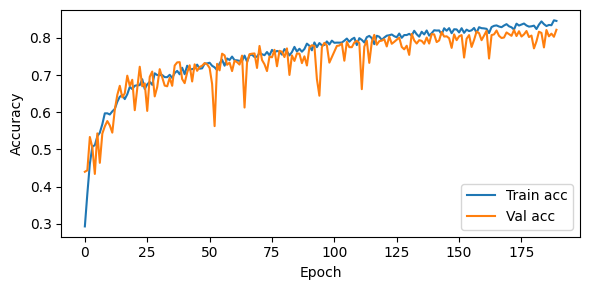

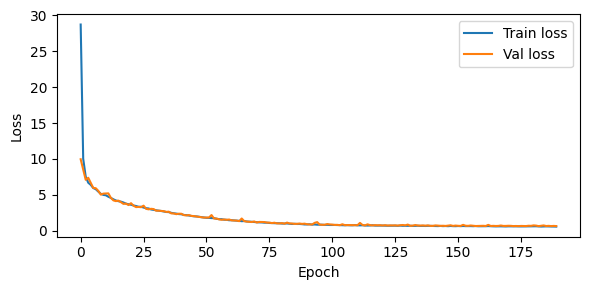

In [83]:
plt.figure(figsize=(6,3))
plt.plot(fitted.history["accuracy"], label="Train acc")
plt.plot(fitted.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fitted.history["loss"], label="Train loss")
plt.plot(fitted.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

## Results

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Test MCC: 0.4997794004575942

Confusion Matrix:
[[28306  6877    25     0  1437   157  5566]
 [12638 32094  1841    62  7040  2161   825]
 [    6   120  5266   415   119  1225     0]
 [    0     0     7   538     0     4     0]
 [   11    59    29     0  1757    43     0]
 [    0    77   295   255    70  2776     0]
 [  148     5     2     0     2     0  3945]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     42368
           1       0.82      0.57      0.67     56661
           2       0.71      0.74      0.72      7151
           3       0.42      0.98      0.59       549
           4       0.17      0.93      0.29      1899
           5       0.44      0.80      0.56      3473
           6       0.38      0.96      0.55      4102

    accuracy                           0.64    116203
   macro avg       0.52      0.81      0.58    116203
weighted avg       0.72    

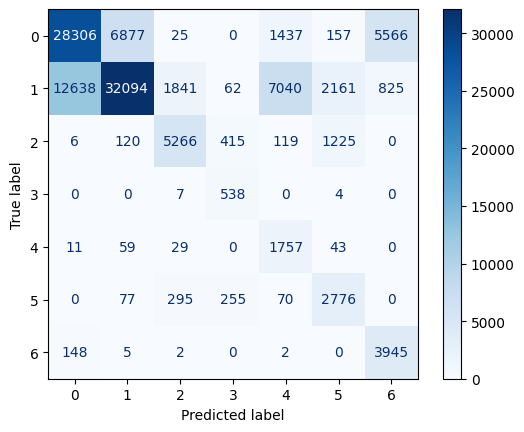

In [84]:
# See how our model does on the test set

# TODO: deal with softmax to a prediction and fix model rigidness.
# todo: categorize using sklearn on the y_true
y_predicted = model.predict(X_test)

# take argmax of y_predicted to find what it predicted
y_pred_idx = [np.argmax(row) for row in y_predicted]

test_mcc = matthews_corrcoef(y_test, y_pred_idx)
print("Test MCC:", test_mcc)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_idx))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_idx))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_idx, cmap="Blues")
plt.show()

In [85]:
# dump model
dump(model, "../data/best_neural_network5.joblib")

['../data/best_neural_network5.joblib']